# VGGNet

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/09_VGGNet.ipynb)

VGGNet fue desarrollada en 2014 por el Visual Geometry Group de Oxford. Los componentes son exactamente los mismos que los de LeNet y AlexNet, excepto que VGGNet es una red aún más profunda con más capas convolucionales y densas. Aparte de eso, no introduce nuevos componentes. 

El concepto novedoso de VGGNet es que tiene una arquitectura simple que contienen componentes uniformes, con lo cual reduce la cantidad de hiperparámetros, haciendo el proceso de tuning menos doloroso. 

- Todas las capas convolucionales tienen filtros de de 3 × 3 con un valor de stride de 1
- Todas las capas de pooling tienen filtros de tamaño 2 y strides de tamaño 2


La idea es que dado un campo receptivo, múltiples filtros más pequeños se comportan mejor que un filtro más grande porque aprenden detalles más finos, a la vez que es menos costoso apilar muchos de ellos. La mayor profundidad de la red, además permite componer mejor las distintas escalas espaciales. 

<!-- ![La arquitectura VGGNet-16](images/vggnet_architecture.png) -->

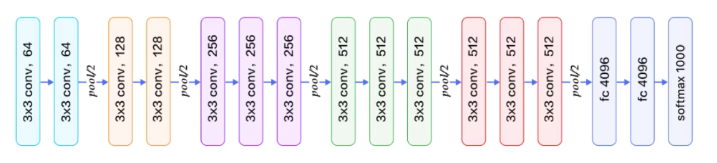

## Configuraciones de VGGNet

<!-- ![Posibles configuraciones de VGGNet](images/vggnet_configurations.png) -->

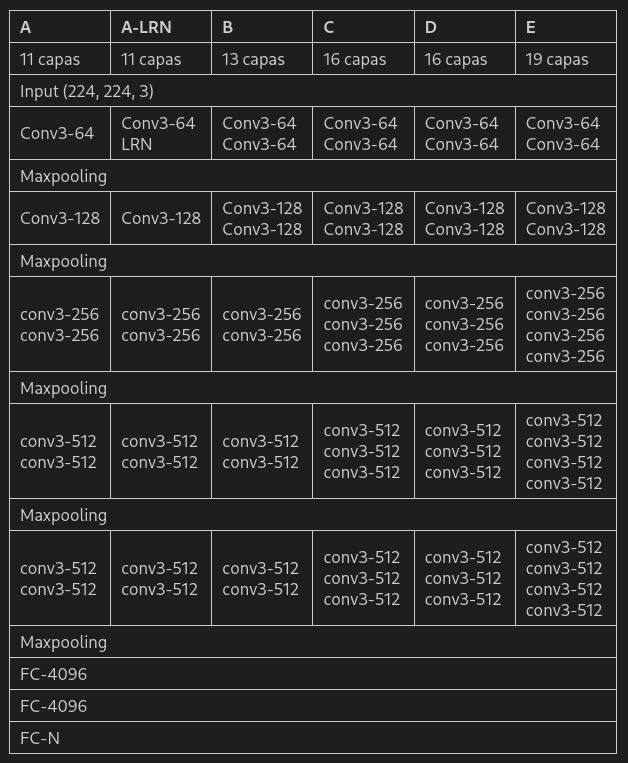

## Arquitectura basada en VGGNet

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l2
import numpy as np
import seaborn as sns
sns.set_theme()

2023-07-02 17:12:26.333937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 17:12:27.888342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:12:27.891557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:12:27.891672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
num_classes = 10

# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('cifar10', split=["train", "test"], with_info=True, as_supervised=True)

def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)


# initiliaze the color normalization layer
normalization_layer = layers.Normalization(axis=None)
normalization_layer.adapt(train_data.map(normalize).map(lambda x, y: x))


def pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.map(to_categorical)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 64

batched_train_data = processed_train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2023-07-02 17:12:27.911729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:12:27.911866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:12:27.911970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom((-0.2, 0.2)),
  layers.RandomTranslation(
    (-0.1, 0.1), (-0.1, 0.1)
  ),
  layers.RandomRotation(0.2),
])

In [5]:
batched_train_data = batched_train_data.map(lambda x, y: (data_augmentation(x), y))

In [6]:
def create_model(input_shape=[224, 224, 3], num_classes=10, activation="relu", pooling_layer=layers.MaxPooling2D, batch_normalization=True, kernel_regularizer=l2(5e-4)):

    model = Sequential()
    
    # Ejercicio: implementar VGGNet-16 y VGGNet-19

    return model

In [7]:
model = create_model()

# model.summary()

In [8]:
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=np.sqrt(0.1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(
    batched_train_data,
    epochs=10,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)